In [ ]:
!pip install prophet statsmodels

In [1]:
import datetime
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ModuleNotFoundError: No module named 'pandas'

# Loading the dataset

In [2]:
import kagglehub

#Download latest version
path = kagglehub.dataset_download("prasoonkottarathil/ethereum-historical-dataset")
print("Path to dataset files:", path)

100%|██████████| 21.4M/21.4M [00:00<00:00, 77.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prasoonkottarathil/ethereum-historical-dataset/versions/2


In [3]:
cd /root/.cache/kagglehub/datasets/prasoonkottarathil/ethereum-historical-dataset/versions/2/

/root/.cache/kagglehub/datasets/prasoonkottarathil/ethereum-historical-dataset/versions/2


In [4]:
ls

ETH_1H.csv  ETH_1min.csv  ETH_day.csv


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [50]:
# Load daily, hourly, and minute data
day_data = pd.read_csv('ETH_day.csv')
hour_data = pd.read_csv('ETH_1H.csv')
minute_data = pd.read_csv('ETH_1min.csv')

In [51]:
hour_data.Date = pd.to_datetime(hour_data['Date'])
minute_data.Date = pd.to_datetime(minute_data['Date'])
day_data.Date = pd.to_datetime(day_data['Date'])

In [52]:
# Extract useful time features from Unix Timestamp or Date (for hourly and minute data)
hour_data['Hour'] = hour_data['Date'].dt.hour
hour_data['Day'] = hour_data['Date'].dt.day
hour_data['Month'] = hour_data['Date'].dt.month

minute_data['Hour'] = minute_data['Date'].dt.hour
minute_data['Day'] = minute_data['Date'].dt.day
minute_data['Month'] = minute_data['Date'].dt.month

day_data['Day'] = day_data['Date'].dt.day
day_data['Month'] = day_data['Date'].dt.month

In [29]:
day_data.shape

(1438, 8)

In [33]:
1438 * 34497

49606686

In [32]:
hour_data.shape

(34497, 8)

In [34]:
day_data.head(2)

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
1,2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44


In [39]:
hour_data.head(2)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299


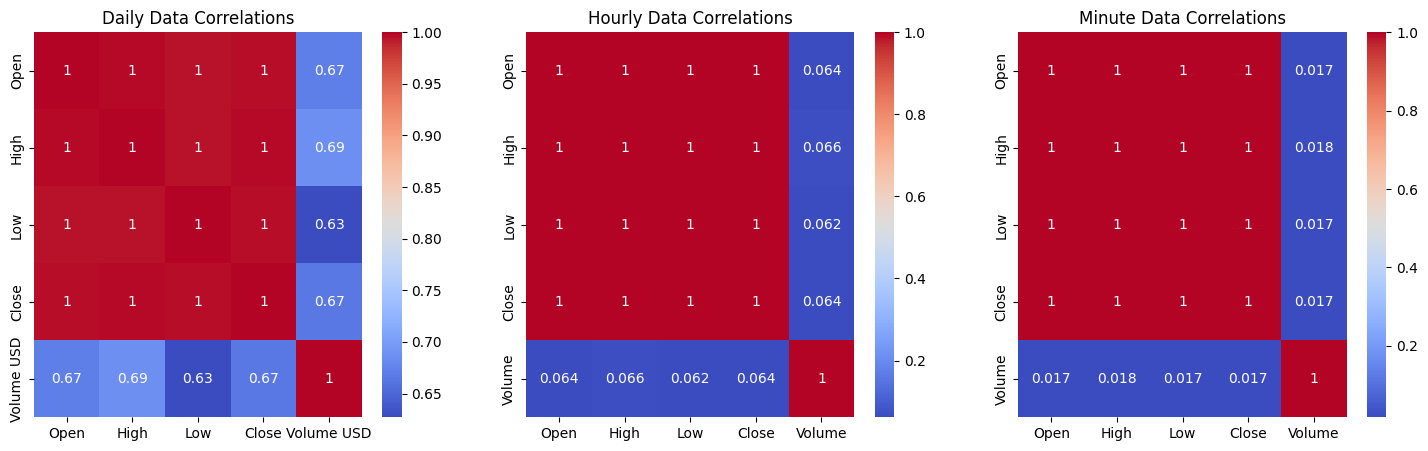

In [42]:
import seaborn as sns

# Compute correlations for daily, hourly, and minute data
day_corr = day_data[['Open', 'High', 'Low', 'Close', 'Volume USD']].corr()
hour_corr = hour_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
minute_corr = minute_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(day_corr, annot=True, ax=axes[0], cmap='coolwarm')
axes[0].set_title('Daily Data Correlations')

sns.heatmap(hour_corr, annot=True, ax=axes[1], cmap='coolwarm')
axes[1].set_title('Hourly Data Correlations')

sns.heatmap(minute_corr, annot=True, ax=axes[2], cmap='coolwarm')
axes[2].set_title('Minute Data Correlations')

plt.show()

Volatality

<ipython-input-43-eff142add4ba>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Daily', 'Hourly', 'Minute'])


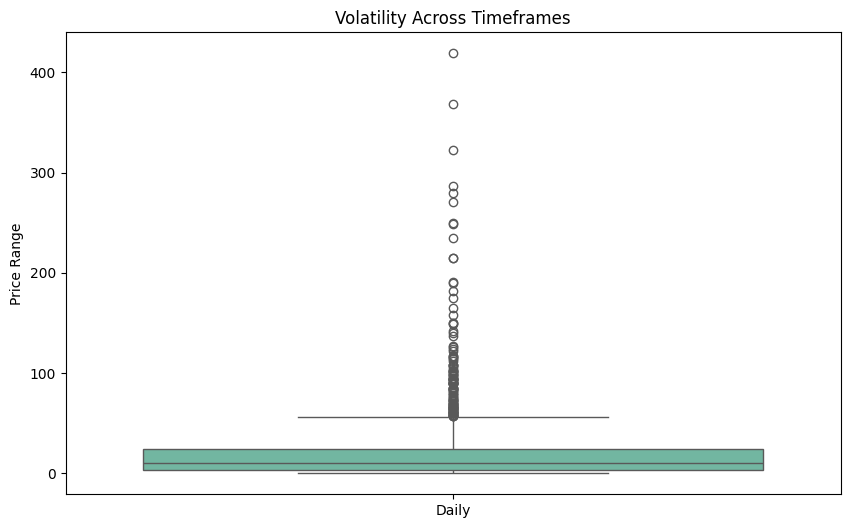

In [43]:
# Compute daily price ranges
day_data['Price Range'] = day_data['High'] - day_data['Low']

# Box plot of daily, hourly, and minute volatility
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=[day_data['Price Range'],
                  hour_data['High'] - hour_data['Low'],
                  minute_data['High'] - minute_data['Low']],
            palette="Set2")
ax.set_xticklabels(['Daily', 'Hourly', 'Minute'])
plt.title('Volatility Across Timeframes')
plt.ylabel('Price Range')
plt.show()

Hour data

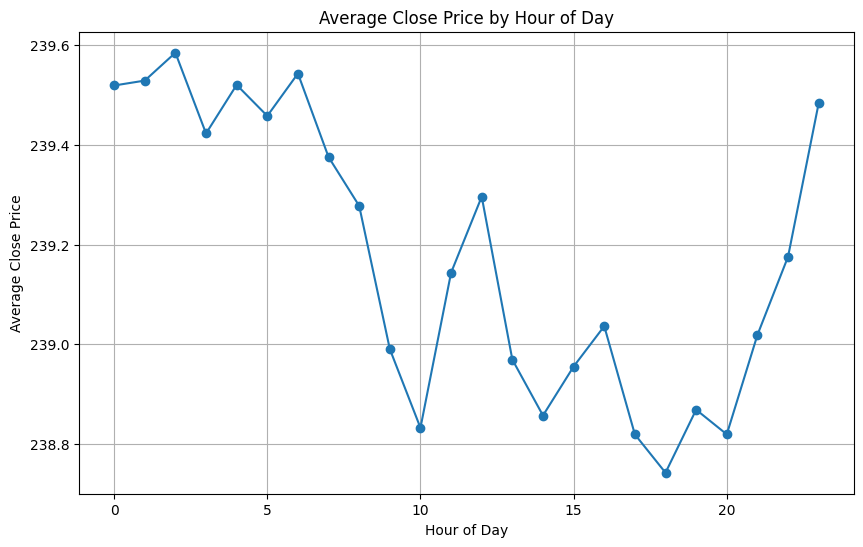

In [44]:
# Aggregate hourly Close prices by hour of the day
hour_data['Hour'] = pd.to_datetime(hour_data['Date']).dt.hour
hourly_avg = hour_data.groupby('Hour')['Close'].mean()

plt.figure(figsize=(10, 6))
hourly_avg.plot(kind='line', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Close Price')
plt.title('Average Close Price by Hour of Day')
plt.grid()
plt.show()

In [57]:
hour_data.head(2)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,Hour,Day,Month
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125,0,16,4
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299,23,15,4


In [54]:
# # Ensure the Date column is in datetime format
# hour_data['Date'] = pd.to_datetime(hour_data['Date'])

# Extract the date (day) from the datetime column
# hour_data['Day'] = hour_data['Date'].dt.date  # Only keep the day part

# Compute daily averages from hourly data
daily_avg = hour_data.groupby('Day')['Close'].mean()

In [56]:
daily_avg.shape

(31,)

In [48]:
# Merge the daily averages back to the hourly dataframe
hour_data = hour_data.merge(daily_avg, on='Day', suffixes=('', '_DailyAvg'))

In [49]:
hour_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,Hour,Day,Month,Close_DailyAvg,Normalized_Close,Close_DailyAvg
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125,0,2020-04-16,4,150.39000,1.000000,150.39000
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299,23,2020-04-15,4,157.90875,0.968534,157.90875
2,1586988000000,2020-04-15 22:00:00,ETHUSD,157.18,157.30,155.32,155.81,106.337279,22,2020-04-15,4,157.90875,0.986709,157.90875
3,1586984400000,2020-04-15 21:00:00,ETHUSD,158.04,158.31,157.16,157.18,55.244131,21,2020-04-15,4,157.90875,0.995385,157.90875
4,1586980800000,2020-04-15 20:00:00,ETHUSD,157.10,158.10,156.87,158.04,144.262622,20,2020-04-15,4,157.90875,1.000831,157.90875


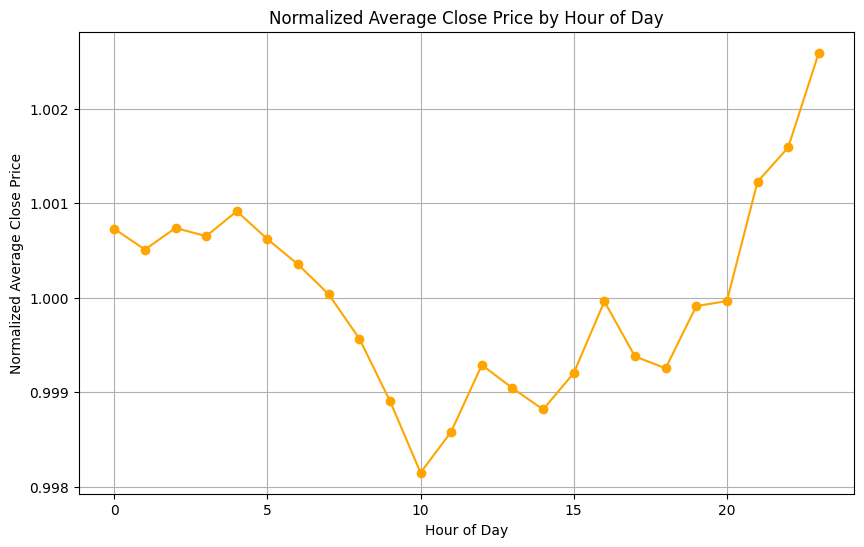

In [45]:




# Normalize hourly Close prices by dividing by the daily average
hour_data['Normalized_Close'] = hour_data['Close'] / hour_data['Close_DailyAvg']

# Compute normalized average Close prices per hour of the day
hour_data['Hour'] = hour_data['Date'].dt.hour
normalized_hourly_avg = hour_data.groupby('Hour')['Normalized_Close'].mean()

# Plot the normalized hourly Close prices
plt.figure(figsize=(10, 6))
normalized_hourly_avg.plot(kind='line', marker='o', color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Average Close Price')
plt.title('Normalized Average Close Price by Hour of Day')
plt.grid()
plt.show()

In [76]:
hour_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299
2,1586988000000,2020-04-15 22:00:00,ETHUSD,157.18,157.30,155.32,155.81,106.337279
3,1586984400000,2020-04-15 21:00:00,ETHUSD,158.04,158.31,157.16,157.18,55.244131
4,1586980800000,2020-04-15 20:00:00,ETHUSD,157.10,158.10,156.87,158.04,144.262622


In [19]:
day_data.rename(columns={'Close': 'Day_Close'}, inplace=True)
hour_data.rename(columns={'Close': 'Hour_Close'}, inplace=True)
minute_data.rename(columns={'Close': 'Minute_Close'}, inplace=True)1

In [20]:
day_data.rename(columns={'Volume': 'Day_Volume'}, inplace=True)
hour_data.rename(columns={'Volume': 'Hour_Volume'}, inplace=True)
minute_data.rename(columns={'Volume': 'Minute_Volume'}, inplace=True)

In [73]:
hour_data.head()

,Symbol,Day,Month,Hour_Close,Hour_Volume
0,ETHUSD,1,1,253.432396,728.534186
1,ETHUSD,1,2,344.690938,2076.858520
2,ETHUSD,1,3,309.120833,3679.320524
3,ETHUSD,1,4,176.276250,928.422150
4,ETHUSD,1,5,298.450833,2403.385474


In [22]:
# Merge data based on 'Symbol' and time
hour_data = hour_data.groupby(['Symbol', 'Day', 'Month']).agg({'Hour_Close': 'mean', 'Hour_Volume': 'mean'}).reset_index()
minute_data = minute_data.groupby(['Symbol', 'Day', 'Month']).agg({'Minute_Close': 'mean', 'Minute_Volume': 'mean'}).reset_index()

# More Visualizations

In [6]:
df = pd.read_csv('ETH_day.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1438 non-null   object 
 1   Symbol      1438 non-null   object 
 2   Open        1438 non-null   float64
 3   High        1438 non-null   float64
 4   Low         1438 non-null   float64
 5   Close       1438 non-null   float64
 6   Volume ETH  1438 non-null   float64
 7   Volume USD  1438 non-null   float64
dtypes: float64(6), object(2)
memory usage: 90.0+ KB


In [8]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
1,2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44
2,2020-04-13,ETHUSD,158.56,159.51,150.12,156.97,15698.32,2416728.28
3,2020-04-12,ETHUSD,158.66,165.37,155.21,158.56,12877.33,2082804.05
4,2020-04-11,ETHUSD,158.26,161.49,154.25,158.66,13761.72,2172914.57


In [9]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [10]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,,,
2020-04-15,2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
2020-04-14,2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44
2020-04-13,2020-04-13,ETHUSD,158.56,159.51,150.12,156.97,15698.32,2416728.28
2020-04-12,2020-04-12,ETHUSD,158.66,165.37,155.21,158.56,12877.33,2082804.05
2020-04-11,2020-04-11,ETHUSD,158.26,161.49,154.25,158.66,13761.72,2172914.57


In [11]:
del df['Date']

In [12]:
df.head()

,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,,
2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44
2020-04-13,ETHUSD,158.56,159.51,150.12,156.97,15698.32,2416728.28
2020-04-12,ETHUSD,158.66,165.37,155.21,158.56,12877.33,2082804.05
2020-04-11,ETHUSD,158.26,161.49,154.25,158.66,13761.72,2172914.57


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load your data
df.index = pd.to_datetime(df.index)  # Ensure the index is datetime
df = df.sort_index()  # Sort by datetime

# Prepare the data for Prophet
data = df[['Close']].reset_index()
data.columns = ['ds', 'y']  # Rename columns for Prophet

In [15]:
data.head()

,ds,y
0,2016-05-09,9.98
1,2016-05-10,9.68
2,2016-05-11,10.43
3,2016-05-12,10.20
4,2016-05-13,10.69


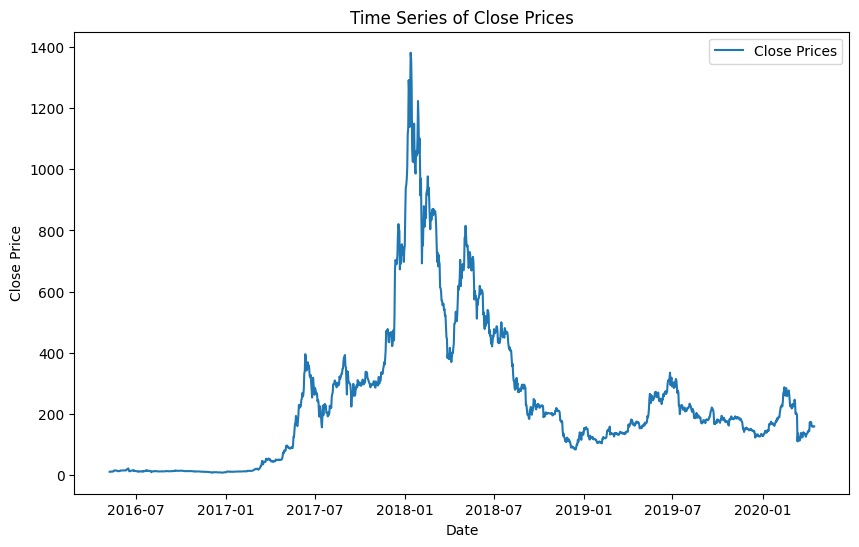

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(data['ds'], data['y'], label="Close Prices")
plt.title("Time Series of Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

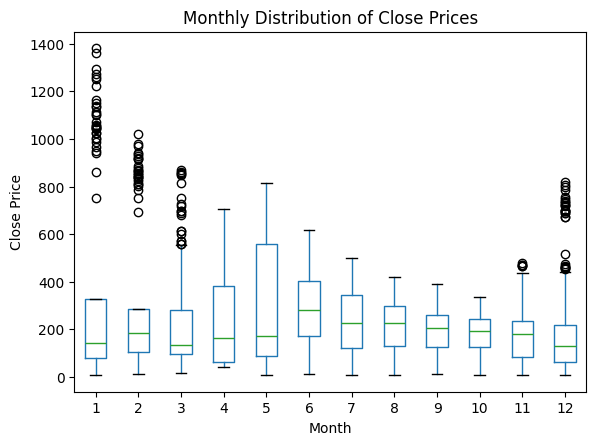

In [17]:
data['month'] = data['ds'].dt.month
plt.figure(figsize=(10, 6))
data.boxplot(column='y', by='month', grid=False)
plt.title("Monthly Distribution of Close Prices")
plt.suptitle("")  # Remove default suptitle
plt.xlabel("Month")
plt.ylabel("Close Price")
plt.show()

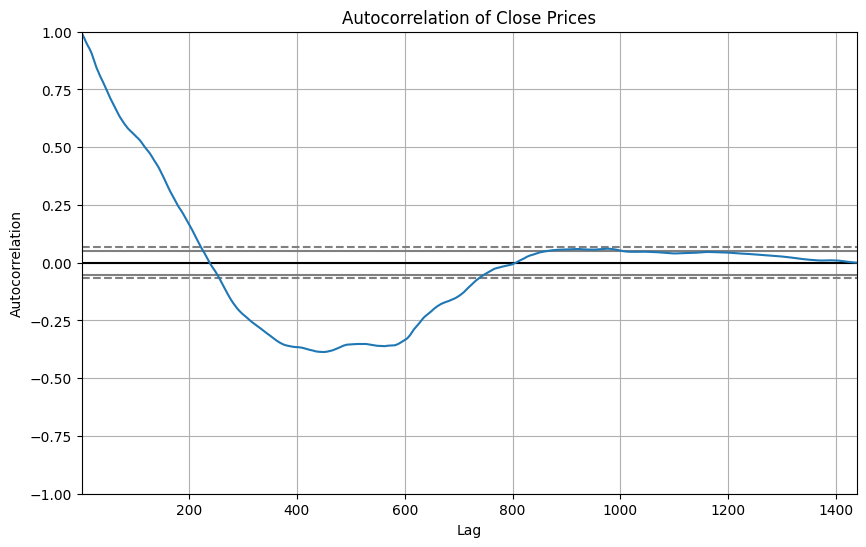

In [18]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(data['y'])
plt.title("Autocorrelation of Close Prices")
plt.show()

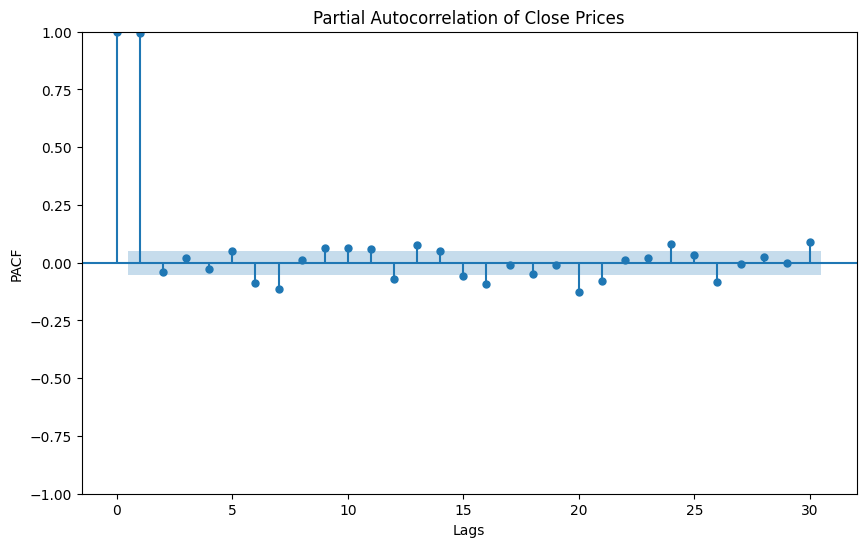

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

# Generate PACF plot
plt.figure(figsize=(10, 6))
plot_pacf(data['y'], lags=30, method='ywm', ax=plt.gca())  # Adjust lags as needed
plt.title("Partial Autocorrelation of Close Prices")
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

# LSTM model based on 'Close'

In [20]:
# Select the target column for forecasting
target_column = 'Close'
series = df[target_column]

In [21]:
from sklearn.model_selection import train_test_split

train_size = 0.8  # Use 80% of the data for training
train, test = train_test_split(series, test_size=1 - train_size, shuffle=False)

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [23]:
# Prepare data
lookback = 10  # Number of past observations to use for prediction
X, y = [], []
for i in range(lookback, len(train)):
    X.append(train[i-lookback:i].values)
    y.append(train[i])

X, y = np.array(X), np.array(y)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

<ipython-input-23-17b42333e301>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(train[i])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 103096.7266
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5113.7642
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9390.2363
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25513.5898
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7207.7573
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3829.5115
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3971.9021
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4405.0234
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4042.3801
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15395.8984
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7246.6094
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7260.4907
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7799.2427
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10876.0078
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━

In [24]:
# Forecast
test_X = []
for i in range(lookback, len(test)):
    test_X.append(test[i-lookback:i].values)

test_X = np.array(test_X).reshape((-1, lookback, 1))
predictions = model.predict(test_X)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


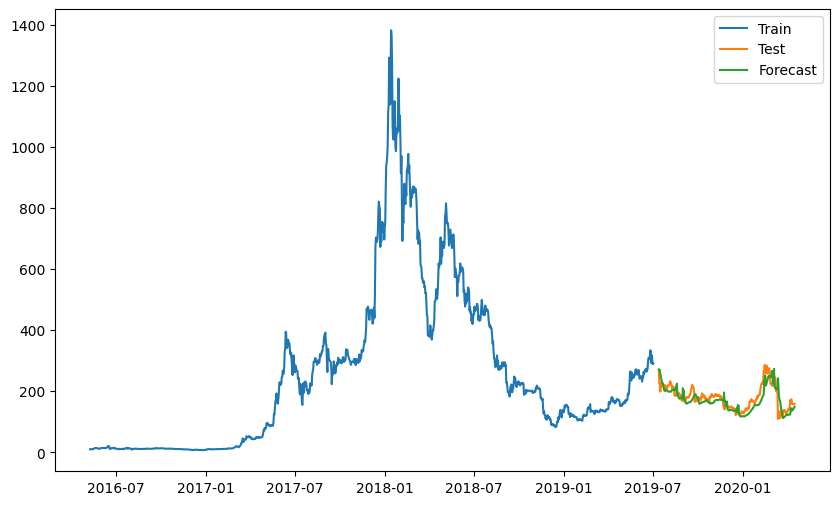

In [25]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index[lookback:], test[lookback:], label="Test")
plt.plot(test.index[lookback:], predictions, label="Forecast")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test[lookback:], predictions)
mse = mean_squared_error(test[lookback:], predictions)
print(f"MAE: {mae}, MSE: {mse}")

MAE: 19.546779414115193, MSE: 622.4478422525785
